In [31]:
import numpy as np
import matplotlib.pyplot as plt

Globals and Helpers

In [32]:
# We'll store baby sleep states and parent sleep states over time (discretized).
# We'll track "epsilon" variations cumulatively

total_eps = 0.0    # For tracking baby state randomness
sleep_tracker = [] # For storing the parent's sleep/awake state at each time step

# constants for cost calculation
K = 1.0 # factor for the denominator
alpha = 0.5 # scales Z(t)
beta = 1.0 # I DON'T KNOW
# delta_t = 1.0 # discrete time step (hours)

def eps_tracker(eps):
    """
    Accumulate the random perturbation (eps) to model unpredictability.
    We'll treat 'eps' as a single float, or an array chunk, 
    then return the updated total.
    """
    global total_eps
    total_eps += eps
    return total_eps

def parent_sleep_tracker(val):
    """
    Append the parent's sleep/awake state for the current time step.
    """
    global sleep_tracker
    sleep_tracker.append(val)
    return sleep_tracker

Modeling Functions

In [33]:
def delta(t):
    """
    Weighted coefficient for night vs. day:
      - 0.9 if 0 < t < 8 (Night)
      - 0.1 if 8 <= t <= 24 (Day)
    """
    if 0 <= t < 8:
        return 0.9
    elif 8 <= t <= 24:
        return 0.1
    # Return something default if out of range:
    return 0.1

def B(t, eps):
    """
    Baby sleep state: 1 = baby asleep, 0 = baby awake.
    We incorporate an epsilon shift in t for unpredictability.
    
    we pass in a single eps or an array-based shift for discrete steps.

    We'll do a piecewise approach:
    - For 0..3 hours, baby is asleep (B=1).
    - For 3..4 hours, baby is awake (B=0).
    Then repeat every 4 hours with a shift by eps.
    """
    # Combine time with the epsilon shift:
    t_adj = t - eps  # Shift time by eps

    # Find a 4-hour block in which t_adj belongs:
    # We'll do mod 4 so it repeats:
    mod_block = t_adj % 4  # remainder in [0, 4)

    # If mod_block < 3 => baby asleep, else baby awake
    if 0 <= mod_block < 3:
        return 1
    else:
        return 0

def w(t):
    """
    Placeholder function: Work or childcare obligations at time t.
    """
    if 9 <= t < 17:
        return 1
    else:
        return 0.0

def Z(t):
    """Random baby-driven disruptions or unpredictablity (placeholder)"""
    return np.random.normal(0, 0.1)

def u_control(t, baby_state, cumulative_sleep):
    """
    The parent's control: 1 = parent chooses to sleep, 0 = parent chooses to be awake.
    This is where we can try our "optimal control" strategies or test strategies
    
    For now, the naive policy: 
    'Parent tries to sleep if baby is asleep (B=1) and it's night.'
    """
    if baby_state == 0:
        return 0  # Must be awake if baby is awake
    else:
        # baby is asleep => choose whether to sleep:
        if 0 <= t <= 8:
            # It's 'night': definitely sleep
            return 1
        else:
            if w(t) ==  1 or cumulative_sleep >= 9:
            # It's 'day' and parent has responsibilities or has already slept 10 hrs, stay up
                return 0
            else: 
                return 1


def Dp(time_index):
    """
    Return the parent's uninterrupted sleep duration at discrete time step 'time_index'.
    We look backward in 'sleep_tracker' until we hit an awake state (0) or start of array.
    """
    if sleep_tracker[time_index] == 0:
        return 0
    # Accumulate how many consecutive steps of '1' up to time_index
    dur = 0
    for i in range(time_index, -1, -1):  # walk backward
        if i == 0:
            break
        elif sleep_tracker[i] == 1:
            dur += 1
        else:
            break
    return dur  # in discrete steps (hours, if dt=1)

def Np(time_index):
    """
    Return the number of distinct 'sleep intervals' from t0 up to time_index.
    We'll increment count each time we see a 0->1 transition in sleep_tracker.
    """
    if time_index <= 0:
        return 0
    num_naps = 0
    for i in range(1, time_index+1):
        if sleep_tracker[i] == 1 and sleep_tracker[i-1] == 0:
            num_naps += 1
    return num_naps

In [34]:
# === Parameters ===
T = 24                      # Final time
dt = 0.1                    # Time step
Nt = int(T / dt) + 1        # Number of time steps
time = np.linspace(T, 0, Nt)  # Backward in time
beta = 0.5                  # Cost weight (adjust as needed)
eps = 0.2                   # Time shift for baby unpredictability
sleep_tracker = np.zeros(Nt)  # Track sleep states (initialize properly)

x_min, x_max, dx = -25, 25, 0.1  # State space range and resolution
x_grid = np.arange(x_min, x_max + dx, dx)
Nx = len(x_grid)


# === Control options (bang-bang) ===
controls = [0.0, 1.0]

# === Initialization ===
V = np.full((Nx, Nt), np.inf)   # Value function
U = np.zeros((Nx, Nt))          # Optimal control policy
V[:, 0] = -x_grid                # Terminal condition: -x(tf)

# === HJB Backward Iteration ===
for ti in range(1, Nt):
    t_now = time[ti]
    V_prev = V[:, ti - 1]

    for xi, x in enumerate(x_grid):
        min_cost = np.inf
        best_u = 0.0

        for u in controls:
            # State update using dynamics: x' = delta(t) * u(t)
            x_next = x + dt * delta(t_now) * u

            # Linear interpolation for V(x_next, t - dt)
            if x_min <= x_next <= x_max:
                i_low = int((x_next - x_min) / dx)
                i_high = min(i_low + 1, Nx - 1)
                alpha = (x_next - x_grid[i_low]) / dx
                V_interp = (1 - alpha) * V_prev[i_low] + alpha * V_prev[i_high]
            else:
                V_interp = np.inf  # Out of bounds

            # Stage cost
            running_cost = (1 - B(t_now, eps)) * beta * u + w(t_now) * u - (x ** 2) / max(Np(ti), 1)
            cost = dt * running_cost + V_interp

            # Minimize
            if cost < min_cost:
                min_cost = cost
                best_u = u

        # Update value function and policy
        V[xi, ti] = min_cost
        U[xi, ti] = best_u

C:\Users\sophi\AppData\Local\Temp\ipykernel_16664\923078157.py:41: RuntimeWarning: invalid value encountered in scalar multiply
  V_interp = (1 - alpha) * V_prev[i_low] + alpha * V_prev[i_high]


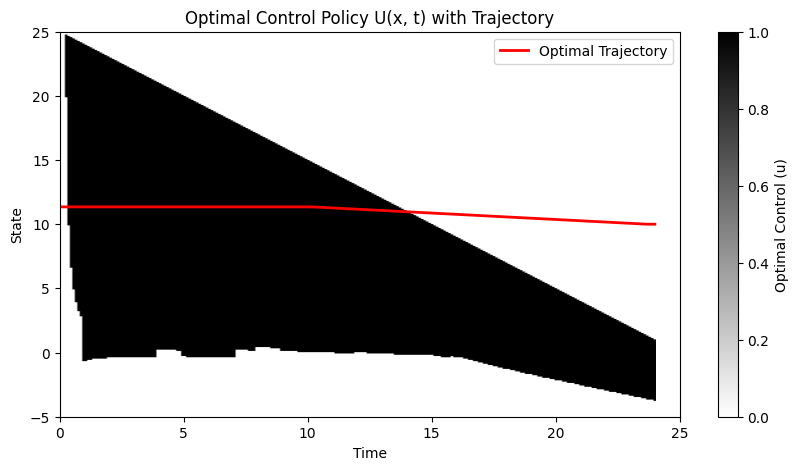

In [35]:
x0 = 10.0  # Starting state
x_traj = [x0]
t_traj = [time[0]]

x_curr = x0

for ti in range(Nt - 1):
    # Clamp x within bounds
    x_clamped = np.clip(x_curr, x_min, x_max)
    xi = int((x_clamped - x_min) / dx)

    u = U[xi, ti]  # Optimal control at this state/time
    x_next = x_curr + dt * delta(time[ti]) * u

    x_traj.append(x_next)
    t_traj.append(time[ti + 1])
    x_curr = x_next


plt.figure(figsize=(10, 5))
plt.imshow(U, extent=[0, T, x_min, x_max], aspect='auto', origin='lower', cmap='gray_r')
plt.plot(t_traj, x_traj, color='red', linewidth=2, label='Optimal Trajectory')
plt.colorbar(label='Optimal Control (u)')
plt.xlabel('Time')
plt.ylabel('State')
plt.xlim(0, 25)
plt.ylim(-5,25)
plt.title('Optimal Control Policy U(x, t) with Trajectory')
plt.legend()
plt.show()


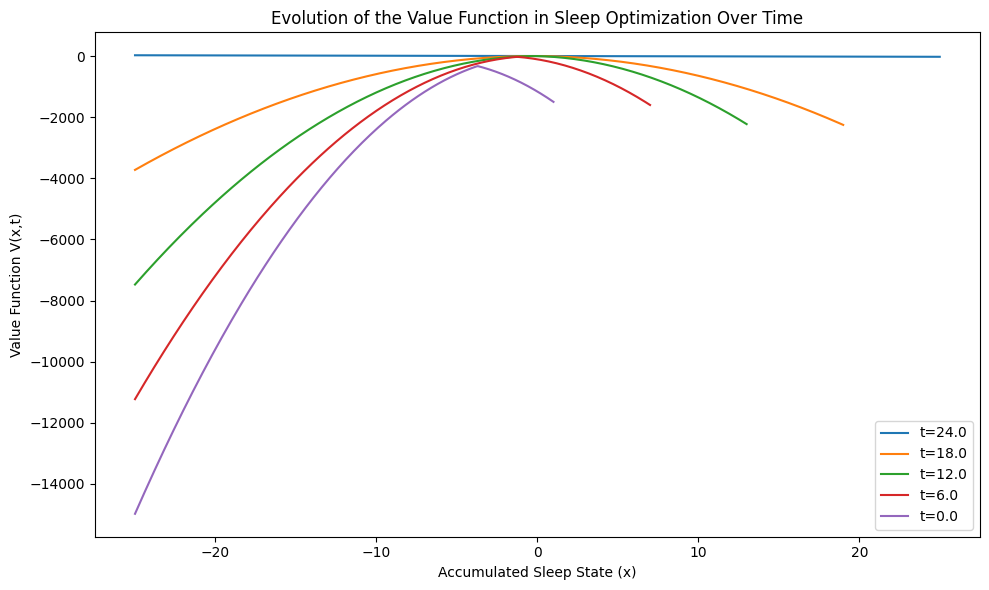

In [36]:
plt.figure(figsize=(10, 6))
for t_physical in [24.0, 18.0, 12.0, 6.0, 0.0]:
    # Convert to correct array index in your backward-time setup
    t_idx = int((T - t_physical)/dt)
    
    # Check your index is in bounds
    if t_idx >= 0 and t_idx < Nt:
        plt.plot(x_grid, V[:, t_idx], label=f't={t_physical:.1f}')
    
plt.xlabel('Accumulated Sleep State (x)')
plt.ylabel('Value Function V(x,t)')
plt.title('Evolution of the Value Function in Sleep Optimization Over Time')
plt.legend()
plt.tight_layout()
plt.show()


Insights: Symmetry around x=0 signifies that sleep deficit and sleep excess are both penalized. There is diminishing impact near terminal time.